セグメントから最適化

In [15]:
from pulp import LpProblem, LpVariable, LpMaximize, LpStatus, lpSum, value
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import math
import seaborn as sns
import time

In [16]:
# Read files
files = glob('../*/*coupon/*.csv')
cust_df = pd.read_csv(files[0])
prob_df = pd.read_csv(files[1])
# print(files)
# print(cust_df.shape)
# print(prob_df.shape)
display(cust_df.head(3))
display(prob_df.head(3))

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0


,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74


In [17]:
# クーポン付与による来客率の増加分を作成
cust_prob_df = prob_df.copy()
cust_prob_df.columns = ['age', 'freq', 'seg_id', 'prob_1', 'prob_2', 'prob_3']

def string_substitution(x):
    tralslate_dict = {
        'age20~34': '20', 'age35~49': '35', 'age~19': '19', 'age50~': '50',
        'freq0': '0', 'freq1': '1', 'freq2': '2', 'freq3~': '3',
    }
    return tralslate_dict[x]

cust_prob_df['age'] = cust_prob_df['age'].apply(string_substitution)
cust_prob_df['freq'] = cust_prob_df['freq'].apply(string_substitution)

for i in range(3):
    cust_prob_df[f'prob_({i+1}-1)'] = cust_prob_df[f'prob_{i+1}'] - cust_prob_df['prob_1']

cust_prob_df

,age,freq,seg_id,prob_1,prob_2,prob_3,prob_(1-1),prob_(2-1),prob_(3-1)
0,19,0,1,0.07,0.12,0.29,0.0,0.05,0.22
1,19,1,2,0.21,0.30,0.58,0.0,0.09,0.37
2,19,2,3,0.28,0.39,0.74,0.0,0.11,0.46
3,19,3,4,0.35,0.45,0.77,0.0,0.10,0.42
4,20,0,5,0.11,0.17,0.37,0.0,0.06,0.26
5,20,1,6,0.32,0.43,0.72,0.0,0.11,0.40
6,20,2,7,0.42,0.55,0.93,0.0,0.13,0.51
7,20,3,8,0.52,0.63,0.94,0.0,0.11,0.42
8,35,0,9,0.08,0.14,0.33,0.0,0.06,0.25
9,35,1,10,0.25,0.35,0.67,0.0,0.10,0.42


In [18]:
# ダイレクトメールの種類と人数を追加し結合
p_df = pd.DataFrame()
for i, (prob, diff) in enumerate(zip(['prob_1', 'prob_2', 'prob_3'], ['prob_(1-1)', 'prob_(2-1)', 'prob_(3-1)'])):
    tmp_df = copy_df[['age', 'freq', 'seg_id', prob, diff]].copy()
    tmp_df['dm'] = i+1
    tmp_df['members'] = cust_df.merge(prob_df, on=['age_cat', 'freq_cat']).groupby('segment_id').count()['customer_id'].to_list()
    tmp_df.columns = ['age', 'freq', 'seg_id', 'prob', 'prob_diff', 'dm', 'members']
    p_df = pd.concat([p_df, tmp_df], axis=0)
# display(p_df.head(3))

In [19]:
# コスト列作成
def cost_calculation(x):
    costs = {1: 0, 2: 1000, 3: 2000}
    return costs[x]
p_df['cost'] = p_df['dm'].apply(cost_calculation)

In [20]:
# 変数列作成
p_df['variable'] = [
    LpVariable(f'x_s{s:02}m{m}', lowBound=0, upBound=1, cat='Continuous') for s, m in zip(p_df['seg_id'], p_df['dm'])
    ]

y = LpVariable(name='y', lowBound=0, upBound=1, cat='Continuous')

# print(p_df.shape)
# display(p_df[p_df['dm'] == 3].head(3))

In [32]:
# Maxmize
problem = LpProblem(name='DiscountCouponProblem02', sense=LpMaximize)

# Maximize visitor rates by coupons
# problem += lpSum(p_df['variable'] * p_df['prob_diff'] * p_df['members'])
# 目的関数を来客率から送付率の最大化に変更
problem += y

# There is always one assignment
for k, v in p_df.groupby('seg_id'):
    problem += lpSum(v['variable'].sum()) == 1

# Below a certain amount
problem += lpSum(p_df['variable'] * p_df['prob'] * p_df['cost'] * p_df['members']) <= 1000000

# segment_each_member_rate_10_percent_or_more
for v in p_df['variable']:
    # problem += v >= 0.1
    problem += v >= y

# print(problem)

In [33]:
# 計算及び結果
time_start = time.time()
status = problem.solve()
time_stop = time.time()
p_df['result'] = p_df['variable'].apply(value)

print(f'Status : {LpStatus[status]}')
print(f'Result : {value(problem.objective):.04}')
print(f'Time : {time_stop - time_start:.03} (sec)')

Status : Optimal
Result : 0.1313
Time : 0.118 (sec)


In [34]:
p_df.head()

,age,freq,seg_id,prob,prob_diff,dm,members,cost,variable,result
0,19,0,1,0.07,0.0,1,200,0,x_s01m1,0.737481
1,19,1,2,0.21,0.0,1,150,0,x_s02m1,0.737481
2,19,2,3,0.28,0.0,1,50,0,x_s03m1,0.737481
3,19,3,4,0.35,0.0,1,100,0,x_s04m1,0.737481
4,20,0,5,0.11,0.0,1,600,0,x_s05m1,0.737481


In [35]:
# すべてのセグメントにおいてresultの合計
for k, v in p_df.groupby('seg_id'):
    print(v['result'].sum(), end=', ')

0.9999999900000001, 0.9999999900000001, 0.9999999900000001, 0.9999999900000001, 0.9999999900000001, 0.9999999900000001, 0.9999999900000001, 0.9999999900000001, 0.9999999900000001, 0.9999999900000001, 0.9999999900000001, 0.9999999900000001, 0.9999999900000001, 0.9999999900000001, 0.9999999900000001, 0.9999999900000001, 

In [36]:
# 予算 1,000,000 以下
(p_df['result'] * p_df['prob'] * p_df['cost'] * p_df['members']).sum()

999999.9674550002

In [37]:
# セグメント別の dm10% 以上
for i, v in enumerate(p_df['result']):
    print(f'{v:.03f}', end=', ')
    if i % 10 == 9:
        print()

0.737, 0.737, 0.737, 0.737, 0.737, 0.737, 0.737, 0.737, 0.737, 0.737, 
0.737, 0.737, 0.737, 0.737, 0.737, 0.737, 0.131, 0.131, 0.131, 0.131, 
0.131, 0.131, 0.131, 0.131, 0.131, 0.131, 0.131, 0.131, 0.131, 0.131, 
0.131, 0.131, 0.131, 0.131, 0.131, 0.131, 0.131, 0.131, 0.131, 0.131, 
0.131, 0.131, 0.131, 0.131, 0.131, 0.131, 0.131, 0.131, 

In [38]:
# 結果
result_df = cust_prob_df.copy()
for i in range(p_df['dm'].nunique()):
    result_df[f'send_dm{i+1}'] = p_df[(p_df['dm'] == i+1)]['result']
result_df.head()

,age,freq,seg_id,prob_1,prob_2,prob_3,prob_(1-1),prob_(2-1),prob_(3-1),send_dm1,send_dm2,send_dm3
0,19,0,1,0.07,0.12,0.29,0.0,0.05,0.22,0.737481,0.131259,0.131259
1,19,1,2,0.21,0.30,0.58,0.0,0.09,0.37,0.737481,0.131259,0.131259
2,19,2,3,0.28,0.39,0.74,0.0,0.11,0.46,0.737481,0.131259,0.131259
3,19,3,4,0.35,0.45,0.77,0.0,0.10,0.42,0.737481,0.131259,0.131259
4,20,0,5,0.11,0.17,0.37,0.0,0.06,0.26,0.737481,0.131259,0.131259


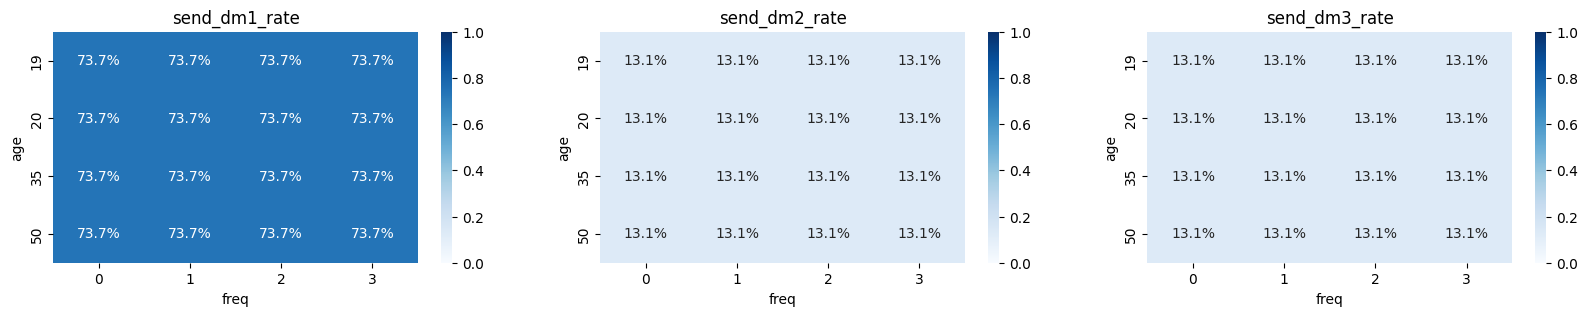

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    send_dm_df = pd.pivot_table(data=result_df, values=ptn, columns='freq', index='age', aggfunc='mean')
    sns.heatmap(send_dm_df, vmin=0, vmax=1, annot=True, fmt='.1%', cmap='Blues', ax=axs[i])
    axs[i].set_title(f'{ptn}_rate')
plt.show()